# TOPIC MODELING
### Notebook guide:
***This notebook has the following parts***
1. **Loading the data set** :  Load the hotel review dataset
2. **Preprocessing** : using mostly textacy library make lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails,remove html_tags punctuation,replace emoji by meaning
3. **select features** : dropping outliers i.e very long text reviews
4. **process for topic modelling** : create a text corpus after removing stopwords,keeping important POS tags,use common words and very uncommon words(gensim dict filtering)
5. **LDA topic modelling for all the reviews** : lda is calculated on the entire corpus
6. **LDA topic modelling for positive and negative reviews** : we only pass corpus for positive and negative for lda
6. **Result analysis** : analysis of the topic model results for positive,negative,neutral reviews

### Note: 
Ratings are converted on a the scale of 0 to 4(from the original scale of 1-5), we can say ratings that are less than 2 are negative ratings and anything more than 2 is positive rating, 2 is neutral rating. This conversion is done for bert training.
### References:
1. https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb
2. https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews/code
3. https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/#h2_1

In [32]:
# !pip install textacy
# !pip install nltk
# !pip install yapf
# !pip install gensim
# !pip install emoji_translate
# !pip install en_core_web_sm
# !pip install pyLDAvis

# 1. Load the dataset 

In [33]:
import pandas as pd

review_org_data = pd.read_csv('../hotel_reviews_assignment/tripadvisor_hotel_reviews.csv')
review_org_dat = review_org_data.dropna().drop_duplicates()
review_org_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [34]:
review_org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [35]:
review_org_data.describe(include='all')

,Review,Rating
count,20491,20491.000000
unique,20491,NaN
top,nice hotel expensive parking got good deal sta...,NaN
freq,1,NaN
mean,NaN,3.952223
std,NaN,1.233030
min,NaN,1.000000
25%,NaN,3.000000
50%,NaN,4.000000
75%,NaN,5.000000


<AxesSubplot:>

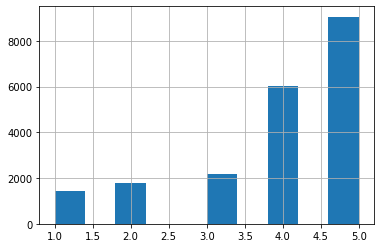

In [36]:
review_org_data['Rating'].hist()

# 2. Preprocessing

In [37]:
import re
import textacy
from textacy import preprocessing
from emoji_translate.emoji_translate import Translator
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

emo = Translator(exact_match_only=False, randomize=True)


def remove_stopword(x):
#     return [y for y in x.split(' ') if y not in stopwords.words('english')]
    return (' ').join([y for y in x.split(' ') if y not in stopwords.words('english')])


def text_preprocessing(text):
    '''
     lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails
     remove html_tags punctuation
     replace emoji by meaning
    '''
    text_new = text.lower()
    text_new = re.sub(' +', ' ', text_new)
    text_new = textacy.preprocessing.replace.hashtags(text_new, repl='_HASH_')
    text_new = textacy.preprocessing.replace.phone_numbers(text_new,
                                                           repl='_PHONENUM_')
    text_new = textacy.preprocessing.remove.html_tags(text_new)
    text_new = textacy.preprocessing.replace.urls(text_new, repl='_URL_')
    text_new = textacy.preprocessing.replace.emails(text_new, repl='_EMAIL_')
    text_new = textacy.preprocessing.remove.punctuation(text_new,
                                                        only=[",", ";", ":"])
    text_new = emo.demojify(text_new)
    text_new = text_new.lower()
    
    return text_new

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trinanjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# check one example
text_preprocessing('I Love #pasta, and this is my phone number 9191919191 with email ts@gmail.com, also check https://twitter.com')

'i love _hash_  and this is my phone number _phonenum_ with email _email_  also check _url_'

In [39]:
%%time
# TODO: using parallel processing here to make it faster
review_org_data['clean_text'] = review_org_data['Review'].apply(
    lambda x: text_preprocessing(x))

CPU times: user 47.6 s, sys: 58.8 ms, total: 47.7 s
Wall time: 47.6 s


# 3. Selecting features

In [40]:
print('converting rating from 0 to 4')
review_org_data['rating_from_0'] = review_org_data['Rating'].apply(
    lambda x: x - 1)

print('creating a column for text length')
review_org_data['text_length'] = review_org_data['clean_text'].apply(
    lambda x: len(x.split(" ")))

converting rating from 0 to 4
creating a column for text length


In [41]:
print('num of reviews having more than 512 words are ', end='')
print(
    len(review_org_data) -
    len(review_org_data[review_org_data['text_length'] < 512]))

num of reviews having more than 512 words are 262


In [42]:
# let's remove them
print('removing outliers ')
review_org_data = review_org_data[review_org_data['text_length'] < 512]

removing outliers 


In [43]:
# review_org_data[review_org_data['rating_from_0'] == 4].sort_values('text_length',ascending=False)

In [44]:
print('Number of reviews after removing long reviews -- ')
len(review_org_data)

Number of reviews after removing long reviews -- 


20229

In [45]:
review_org_data.head()

,Review,Rating,clean_text,rating_from_0,text_length
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,3,98
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,1,270
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,2,233
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monac...,4,102
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game aweso...,4,224


# 4. process for topic modelling

In [46]:
import spacy

import gensim
from gensim import corpora

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/trinanjan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/trinanjan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/trinanjan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [49]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words=set(nltk.corpus.stopwords.words('english'))

def preprocessing_for_topic_modeling(arr_of_text, keep_this_pos_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    final_output = []
    for each_record in arr_of_text:
        _text = nlp(each_record)
        final_output.append([
            each_token.lemma_ for each_token in _text
            if each_token.pos_ in keep_this_pos_tags
            if each_token.text not in stop_words
            if len(each_token.text) > 2
        ])
    return final_output

In [50]:
# check example
preprocessing_for_topic_modeling(['i am loving','the i am testing'])

[['love'], ['test']]

# 5. LDA on entire reviews

In [51]:
review_list= review_org_data['clean_text'].tolist()
print('processing {} reviews for topic modeling ...'.format(len(review_list)), end = '')
tokenized_reviews = preprocessing_for_topic_modeling(review_list)
print('processing done')

processing 20229 reviews for topic modeling ...processing done


In [52]:
print(review_list[0])
print('----------')
print(tokenized_reviews[0])

nice hotel expensive parking got good deal stay hotel anniversary  arrived late evening took advice previous reviews did valet parking  check quick easy  little disappointed non-existent view room room clean nice size  bed comfortable woke stiff neck high pillows  not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway  maybe just noisy neighbors  aveda bath products nice  did not goldfish stay nice touch taken advantage staying longer  location great walking distance shopping  overall nice experience having pay 40 parking night 
----------
['nice', 'hotel', 'expensive', 'parking', 'get', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrive', 'late', 'evening', 'take', 'advice', 'previous', 'review', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'non', 'existent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'wake', 'stiff', 'neck', 'high', 'pillow', 'soundproof', 'hear', 'mus

In [53]:
from gensim.models import Phrases
bigram = Phrases(tokenized_reviews, min_count=10)
trigram = Phrases(bigram[tokenized_reviews])

In [54]:
tokenized_reviews[0]

['nice',
 'hotel',
 'expensive',
 'parking',
 'get',
 'good',
 'deal',
 'stay',
 'hotel',
 'anniversary',
 'arrive',
 'late',
 'evening',
 'take',
 'advice',
 'previous',
 'review',
 'valet',
 'parking',
 'check',
 'quick',
 'easy',
 'little',
 'disappointed',
 'non',
 'existent',
 'view',
 'room',
 'room',
 'clean',
 'nice',
 'size',
 'bed',
 'comfortable',
 'wake',
 'stiff',
 'neck',
 'high',
 'pillow',
 'soundproof',
 'hear',
 'music',
 'room',
 'night',
 'morning',
 'loud',
 'bang',
 'door',
 'open',
 'closing',
 'hear',
 'people',
 'talk',
 'hallway',
 'maybe',
 'noisy',
 'neighbor',
 'aveda',
 'bath',
 'product',
 'nice',
 'goldfish',
 'stay',
 'nice',
 'touch',
 'take',
 'advantage',
 'stay',
 'long',
 'location',
 'great',
 'walking',
 'distance',
 'shop',
 'overall',
 'nice',
 'experience',
 'pay',
 'parking',
 'night']

In [55]:
trigram.vocab

{'nice': 11806,
 'hotel': 49924,
 'nice_hotel': 809,
 'expensive': 1811,
 'hotel_expensive': 112,
 'parking': 868,
 'expensive_parking': 7,
 'get': 7235,
 'parking_get': 3,
 'good': 18972,
 'get_good': 181,
 'deal': 1324,
 'good_deal': 284,
 'stay': 27178,
 'deal_stay': 25,
 'stay_hotel': 2881,
 'anniversary': 225,
 'hotel_anniversary': 7,
 'arrive_late': 122,
 'anniversary_arrive_late': 1,
 'evening': 1687,
 'arrive_late_evening': 13,
 'take': 3995,
 'evening_take': 6,
 'advice': 432,
 'take_advice': 21,
 'previous_review': 132,
 'advice_previous_review': 1,
 'valet_parking': 150,
 'previous_review_valet_parking': 1,
 'check_quick': 89,
 'valet_parking_check_quick': 1,
 'easy': 1727,
 'check_quick_easy': 20,
 'little': 5381,
 'easy_little': 4,
 'disappointed': 451,
 'little_disappointed': 35,
 'non_existent': 50,
 'disappointed_non_existent': 1,
 'view': 4761,
 'non_existent_view': 1,
 'room': 44121,
 'view_room': 440,
 'room_room': 681,
 'clean': 9321,
 'room_clean': 1941,
 'clean_ni

In [56]:
%%time
from tqdm import tqdm as tqdm

for id in tqdm(range(len(tokenized_reviews))):
    for token in bigram[tokenized_reviews[id]]:
        if '_' in token:
            tokenized_reviews[id].append(token)
            
    for token in trigram[tokenized_reviews[id]]:
        if '_' in token:
            tokenized_reviews[id].append(token)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20229/20229 [00:04<00:00, 4873.22it/s]

CPU times: user 4.15 s, sys: 12.1 ms, total: 4.17 s
Wall time: 4.15 s


In [57]:
dictionary = corpora.Dictionary(tokenized_reviews)
dictionary.filter_extremes(no_below=10,no_above=0.5)
doc_term_matrix = [dictionary.doc2bow(review) for review in tokenized_reviews]

In [59]:
len(dictionary)

9067

In [60]:
%%time
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=5,
                chunksize=1000,
                passes=50,
                random_state=2022,
                iterations=100)

CPU times: user 4min 1s, sys: 138 ms, total: 4min 1s
Wall time: 4min 1s


In [61]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)

/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [66]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.118383  0.055268       1        1  28.246651
4     -0.100973 -0.130925       2        1  27.087859
0     -0.057474 -0.119989       3        1  24.718270
1     -0.023966  0.223003       4        1  10.645875
2      0.300795 -0.027357       5        1   9.301346, topic_info=             Term          Freq         Total Category  logprob  loglift
4183       resort   6828.000000   6828.000000  Default  30.0000  30.0000
4343        beach   7831.000000   7831.000000  Default  29.0000  29.0000
34       location  10452.000000  10452.000000  Default  28.0000  28.0000
270       service   9791.000000   9791.000000  Default  27.0000  27.0000
1800  minute_walk   4960.000000   4960.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
336          time   1115.016586  10707.983892   Topic5  -4.9883   0.1129
419     beautiful    885.937783   4246.168490   Topic5  -5.2183   0.8079
464    restaurant    992.264234   8953.822107   Topic5  -5.1050   0.1752
25     experience    850.954730   3734.818350   Topic5  -5.2586   0.8959
112           day    942.311402  11359.195553   Topic5  -5.1566  -0.1144

[354 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
4675      4  0.995937     afternoon_tea
2444      3  0.997646     air_condition
1336      1  0.214020  air_conditioning
1336      2  0.685823  air_conditioning
1336      3  0.099805  air_conditioning
...     ...       ...               ...
794       3  0.139438              year
794       4  0.152409              year
794       5  0.523524              year
1057      5  0.997870          year_ago
1890      5  0.999472          year_old

[644 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])

In [67]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

topic_to_check = lda_model
number_of_topic = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(number_of_topic):
    print('---------------------| Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(topic_to_check,topic_number=i, topn=5, output=True )
    topic_summaries += [tmp[:5]]

term                 frequency

---------------------| Topic 0 |---------------------

beach                0.017
resort               0.016
food                 0.014
pool                 0.011
day                  0.011
---------------------| Topic 1 |---------------------

service              0.014
view                 0.013
bar                  0.009
excellent            0.009
location             0.008
---------------------| Topic 2 |---------------------

make_sure            0.016
service              0.013
train_station        0.012
make                 0.011
highly_recommend     0.010
---------------------| Topic 3 |---------------------

location             0.016
walk                 0.014
breakfast            0.013
clean                0.012
minute_walk          0.010
---------------------| Topic 4 |---------------------

night                0.010
check                0.008
bed                  0.008
day                  0.007
get                  0.006


# 6. LDA only on Positive and negative reviews and Result Analysis

In [70]:
def create_and_run_topic_model(review_list):
    review_list= review_list
    tokenized_reviews = preprocessing_for_topic_modeling(review_list)
    
    bigram = Phrases(tokenized_reviews, min_count=10)
    trigram = Phrases(bigram[tokenized_reviews])
    for id in tqdm(range(len(tokenized_reviews))):
        for token in bigram[tokenized_reviews[id]]:
            if '_' in token:
                tokenized_reviews[id].append(token)

        for token in trigram[tokenized_reviews[id]]:
            if '_' in token:
                tokenized_reviews[id].append(token)
    
    dictionary = corpora.Dictionary(tokenized_reviews)
    dictionary.filter_extremes(no_below=10,no_above=0.2)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]
    
    LDA = gensim.models.ldamodel.LdaModel

    lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=5,
                chunksize=1000,
                passes=50,
                random_state=2022,
                iterations=100)
    return lda_model, doc_term_matrix, dictionary

In [71]:
input_topic_data = review_org_data[review_org_data['rating_from_0'] < 2]
print(len(input_topic_data))
input_topic_data = list(input_topic_data['clean_text'].values)
topic_model_neg,doc_term_matrix_neg,dictionary_neg = create_and_run_topic_model(input_topic_data)

input_topic_data = review_org_data[review_org_data['rating_from_0'] > 2]
print(len(input_topic_data))
input_topic_data = list(input_topic_data['clean_text'].values)
topic_model_pos,doc_term_matrix_pos,dictionary_pos = create_and_run_topic_model(input_topic_data)

input_topic_data = review_org_data[review_org_data['rating_from_0'] == 2]
print(len(input_topic_data))
input_topic_data = list(input_topic_data['clean_text'].values)
topic_model_neu,doc_term_matrix_neu,dictionary_neu = create_and_run_topic_model(input_topic_data)

3151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3151/3151 [00:00<00:00, 4173.96it/s]


14929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14929/14929 [00:03<00:00, 4753.10it/s]


2149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2149/2149 [00:00<00:00, 5026.72it/s]


In [72]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model_neg, doc_term_matrix_neg, dictionary_neg)
vis

/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.068556  0.177067       1        1  24.574166
1      0.089804  0.112364       2        1  21.948772
2     -0.192604 -0.109450       3        1  21.861569
4     -0.005321 -0.070146       4        1  18.875571
0      0.176677 -0.109835       5        1  12.739922, topic_info=                  Term         Freq        Total Category  logprob  loglift
1722            resort  1206.000000  1206.000000  Default  30.0000  30.0000
988        credit_card   494.000000   494.000000  Default  29.0000  29.0000
150   customer_service   473.000000   473.000000  Default  28.0000  28.0000
1569              pool   939.000000   939.000000  Default  27.0000  27.0000
16                call   762.000000   762.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
78               offer   130.177557   561.006599   Topic5  -5.3770   0.5996
278                new   126.001515   466.803103   Topic5  -5.4096   0.7508
341            parking   119.728861   344.182722   Topic5  -5.4606   1.0045
599               give   123.347414   802.235784   Topic5  -5.4308   0.1880
269             little   120.858503   584.122408   Topic5  -5.4512   0.4849

[343 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
325       5  0.993092  2nd_floor
2495      2  0.995198  3rd_floor
433       2  0.203957     access
433       4  0.676279     access
433       5  0.118080     access
...     ...       ...        ...
309       3  0.124680       year
309       5  0.132856       year
1146      1  0.434955   year_old
1146      2  0.564266   year_old
214       4  0.980180  young_man

[633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

In [73]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model_pos, doc_term_matrix_pos, dictionary_pos)
vis

/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.070092  0.196101       1        1  24.868727
0      0.106421  0.036247       2        1  24.713512
2      0.071409 -0.227549       3        1  22.762698
4      0.086372 -0.007032       4        1  18.976424
3     -0.334294  0.002232       5        1   8.678639, topic_info=                Term         Freq        Total Category  logprob  loglift
2973           beach  5620.000000  5620.000000  Default  30.0000  30.0000
2991          resort  4692.000000  4692.000000  Default  29.0000  29.0000
1219     minute_walk  4224.000000  4224.000000  Default  28.0000  28.0000
105   staff_friendly  4874.000000  4874.000000  Default  27.0000  27.0000
671             pool  4990.000000  4990.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
31           morning   457.580500  2000.125842   Topic5  -5.3170   0.9693
579            water   465.484250  2840.912388   Topic5  -5.2999   0.6355
148            floor   435.201731  3533.874162   Topic5  -5.3672   0.3500
39              open   398.786618  1689.470488   Topic5  -5.4546   1.0006
16              door   398.865686  1916.999082   Topic5  -5.4544   0.8744

[346 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1255      4  0.997888     4th_floor
419       3  0.997849     5th_floor
210       1  0.031439        access
210       2  0.065946        access
210       3  0.751476        access
...     ...       ...           ...
2087      2  0.996886  write_review
584       1  0.261799          year
584       2  0.687406          year
584       3  0.050215          year
678       2  0.997407      year_ago

[649 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [74]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [75]:
topic_to_check = topic_model_neg
number_of_topic = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(number_of_topic):
    print('---------------------| Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(topic_to_check,topic_number=i, topn=5, output=True )
    topic_summaries += [tmp[:5]]

term                 frequency

---------------------| Topic 0 |---------------------

star                 0.014
price                0.011
air_conditioning     0.009
rate                 0.009
non_smoking          0.008
---------------------| Topic 1 |---------------------

door                 0.012
floor                0.011
old                  0.009
shower               0.008
sleep                0.008
---------------------| Topic 2 |---------------------

call                 0.012
credit_card          0.010
customer_service     0.010
manager              0.009
guest                0.009
---------------------| Topic 3 |---------------------

resort               0.022
pool                 0.013
water                0.011
drink                0.010
eat                  0.009
---------------------| Topic 4 |---------------------

use                  0.009
minute               0.007
bar                  0.006
hour                 0.006
price                0.005


In [76]:
topic_to_check = topic_model_pos
number_of_topic = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(number_of_topic):
    print('---------------------| Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(topic_to_check,topic_number=i, topn=5, output=True )
    topic_summaries += [tmp[:5]]

term                 frequency

---------------------| Topic 0 |---------------------

wonderful            0.007
highly_recommend     0.007
feel                 0.007
return               0.007
experience           0.006
---------------------| Topic 1 |---------------------

beach                0.021
resort               0.018
pool                 0.014
people               0.009
drink                0.007
---------------------| Topic 2 |---------------------

minute_walk          0.017
staff_friendly       0.016
minute               0.009
city                 0.007
modern               0.007
---------------------| Topic 3 |---------------------

breakfast_buffet     0.014
air_conditioning     0.012
fruit                0.010
coffee               0.010
fresh_fruit          0.009
---------------------| Topic 4 |---------------------

good_value           0.010
price                0.008
check                0.007
use                  0.007
pay                  0.007


/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/pytho

# 7. Result Analysis on Entire data:


****
**1. For LDA I did the following preprocessing, removed stopwords, used POS that are noun,verd,adv,adj.**

**2. Mostly these pos tags are used to express. also remove words that are too less frequent or words that are occuring a lot**

**3. Once I check the results on the entire corpus. the topics are as follows. I feel like it is hard to interpret from these topics. For example topic-0 maybe talking about hotel that are near to beach. topic-3 maybe talking about the what are some advantages of staying at the hotel.**
****

#### let's check the topics on the entire data

In [69]:

topic_to_check = lda_model
number_of_topic = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(number_of_topic):
    print('---------------------| Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(topic_to_check,topic_number=i, topn=5, output=True )
    topic_summaries += [tmp[:5]]

term                 frequency

---------------------| Topic 0 |---------------------

beach                0.017
resort               0.016
food                 0.014
pool                 0.011
day                  0.011
---------------------| Topic 1 |---------------------

service              0.014
view                 0.013
bar                  0.009
excellent            0.009
location             0.008
---------------------| Topic 2 |---------------------

make_sure            0.016
service              0.013
train_station        0.012
make                 0.011
highly_recommend     0.010
---------------------| Topic 3 |---------------------

location             0.016
walk                 0.014
breakfast            0.013
clean                0.012
minute_walk          0.010
---------------------| Topic 4 |---------------------

night                0.010
check                0.008
bed                  0.008
day                  0.007
get                  0.006


/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/trinanjan/.virtualenvs/torch/lib/pytho

# 8.Result Analysis on Positive and negative reviews:

**If we only check the topics for negative ratings(rating less than 2), we can start seeing some important topics and figure out why they are rated low**

**1. topic-0 is talking about hotel aircondition is probably bad**

**2. topic-1 is talking about hotel shower,door and sanity condition which is bad**

**3. topic-2 is talking about hotel booking servies, probably it is difficult to book through credit card**

**4. topic-3 is talking about resort and pool condition**

**5. topic-4 is talking about the bar area, maybe staying in the hotel is expensive**

In [82]:
topic_to_check = topic_model_neg
number_of_topic = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(number_of_topic):
    print('---------------------| Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(topic_to_check,topic_number=i, topn=5, output=True )
    topic_summaries += [tmp[:5]]

term                 frequency

---------------------| Topic 0 |---------------------

star                 0.014
price                0.011
air_conditioning     0.009
rate                 0.009
non_smoking          0.008
---------------------| Topic 1 |---------------------

door                 0.012
floor                0.011
old                  0.009
shower               0.008
sleep                0.008
---------------------| Topic 2 |---------------------

call                 0.012
credit_card          0.010
customer_service     0.010
manager              0.009
guest                0.009
---------------------| Topic 3 |---------------------

resort               0.022
pool                 0.013
water                0.011
drink                0.010
eat                  0.009
---------------------| Topic 4 |---------------------

use                  0.009
minute               0.007
bar                  0.006
hour                 0.006
price                0.005


**If we only check the topics for positive ratings(rating more than 2), we can start seeing some important topics and figure out why they are rated high**

**1. topic-0 is talking about hotel experience**

**2. topic-1 is talking about hotel near to beach, the hotel is a nice resort**

**3. topic-2 is talking about how easy it is to reach the hotel, staffs are friendly**

**4. topic-3 is talking about breakfast food and other foods that are good**

**5. topic-4 is talking it is probably a good value of money, meaning the hotel price is liked by customers**

In [83]:
topic_to_check = topic_model_pos
number_of_topic = 5
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(number_of_topic):
    print('---------------------| Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(topic_to_check,topic_number=i, topn=5, output=True )
    topic_summaries += [tmp[:5]]

term                 frequency

---------------------| Topic 0 |---------------------

wonderful            0.007
highly_recommend     0.007
feel                 0.007
return               0.007
experience           0.006
---------------------| Topic 1 |---------------------

beach                0.021
resort               0.018
pool                 0.014
people               0.009
drink                0.007
---------------------| Topic 2 |---------------------

minute_walk          0.017
staff_friendly       0.016
minute               0.009
city                 0.007
modern               0.007
---------------------| Topic 3 |---------------------

breakfast_buffet     0.014
air_conditioning     0.012
fruit                0.010
coffee               0.010
fresh_fruit          0.009
---------------------| Topic 4 |---------------------

good_value           0.010
price                0.008
check                0.007
use                  0.007
pay                  0.007
